In [1]:
# Author: Bichen Wu (bichen@berkeley.edu) 08/25/2016

"""Evaluation"""
import matplotlib.pyplot as plt # (added) plotting
from matplotlib.legend_handler import HandlerLine2D # (added) plotting

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import cv2
from datetime import datetime
import os.path
import sys
import time

import numpy as np
from six.moves import xrange
import tensorflow as tf

from config import *
from dataset import pascal_voc, kitti
from utils.util import bbox_transform, Timer
from nets import *


data_path = "/rscratch/ruta/squeezeDet/data/KITTI"
image_set = "val_100"
eval_dir = "/rscratch/ruta/logs/squeezeDet/8.8/eval_val"
checkpoint_path = "/rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000"
eval_interval_secs = 60
gpu = 0
run_once = True

In [2]:
def eval_once(saver, ckpt_path, summary_writer, imdb, model):

  with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    # Restores from checkpoint
    saver.restore(sess, ckpt_path)
    # Assuming model_checkpoint_path looks something like:
    #   /ckpt_dir/model.ckpt-0,
    # extract global_step from it.
    global_step = ckpt_path.split('/')[-1].split('-')[-1]

    num_images = len(imdb.image_idx)

    all_boxes = [[[] for _ in xrange(num_images)]
                 for _ in xrange(imdb.num_classes)]

    _t = {'im_detect': Timer(), 'im_read': Timer(), 'misc': Timer()}

    num_detection = 0.0
    for i in xrange(num_images):
      _t['im_read'].tic()
      images, scales = imdb.read_image_batch(shuffle=False)
      _t['im_read'].toc()

      _t['im_detect'].tic()
      det_boxes, det_probs, det_class = sess.run(
          [model.det_boxes, model.det_probs, model.det_class],
          feed_dict={model.image_input:images, model.keep_prob: 1.0})
      _t['im_detect'].toc()

      _t['misc'].tic()
      for j in range(len(det_boxes)): # batch
        # rescale
        det_boxes[j, :, 0::2] /= scales[j][0]
        det_boxes[j, :, 1::2] /= scales[j][1]

        det_bbox, score, det_class = model.filter_prediction(
            det_boxes[j], det_probs[j], det_class[j])

        num_detection += len(det_bbox)
        for c, b, s in zip(det_class, det_bbox, score):
          all_boxes[c][i].append(bbox_transform(b) + [s])
      _t['misc'].toc()

      print ('im_detect: {:d}/{:d} im_read: {:.3f}s '
             'detect: {:.3f}s misc: {:.3f}s'.format(
                i+1, num_images, _t['im_read'].average_time,
                _t['im_detect'].average_time, _t['misc'].average_time))

    print ('Evaluating detections...')
    aps, ap_names = imdb.evaluate_detections(
        eval_dir, global_step, all_boxes)

    print ('Evaluation summary:')
    print ('  Average number of detections per image: {}:'.format(
      num_detection/num_images))
    print ('  Timing:')
    print ('    im_read: {:.3f}s detect: {:.3f}s misc: {:.3f}s'.format(
      _t['im_read'].average_time, _t['im_detect'].average_time,
      _t['misc'].average_time))
    print ('  Average precisions:')

    eval_summary_ops = []
    for cls, ap in zip(ap_names, aps):
      eval_summary_ops.append(
          tf.summary.scalar('APs/'+cls, ap)
      )
      print ('    {}: {:.3f}'.format(cls, ap))
    print ('    Mean average precision: {:.3f}'.format(np.mean(aps)))
    eval_summary_ops.append(
        tf.summary.scalar('APs/mAP', np.mean(aps))
    )
    eval_summary_ops.append(
        tf.summary.scalar('timing/image_detect', _t['im_detect'].average_time)
    )
    eval_summary_ops.append(
        tf.summary.scalar('timing/image_read', _t['im_read'].average_time)
    )
    eval_summary_ops.append(
        tf.summary.scalar('timing/post_process', _t['misc'].average_time)
    )
    eval_summary_ops.append(
        tf.summary.scalar('num_detections_per_image', num_detection/num_images)
    )

    print ('Analyzing detections...')
    stats, ims = imdb.do_detection_analysis_in_eval(
        eval_dir, global_step)
    for k, v in stats.iteritems():
      eval_summary_ops.append(
          tf.summary.scalar(
            'Detection Analysis/'+k, v)
      )

    eval_summary_str = sess.run(eval_summary_ops)
    for sum_str in eval_summary_str:
      summary_writer.add_summary(sum_str, global_step)
    return np.mean(aps)

In [3]:
def evaluate(t, quantize_func, quantize=True):   # (added) parameters: t, quantize_func, quantize=True
  """Evaluate."""
  with tf.Graph().as_default() as g:
    mc = kitti_squeezeDet_config()
    mc.BATCH_SIZE = 1 # TODO(bichen): allow batch size > 1
    mc.LOAD_PRETRAINED_MODEL = False
    model = SqueezeDet(mc, t, quantize_func, quantize, gpu)   # (added) parameters: t, quantize_func, quantize
    
    """(Added) The following printing section"""
    if quantize:
      # TODO(ruta): fix this
      with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
#         print(sess.run(model.tensor_min))
#         print(sess.run(model.tensor_max))
        i = 0
        for tens in sess.run(model.tensor):
          print(i, tens)
          i+=1
#         i = 0
#         for tens in sess.run(model.tensor_normalized):
#           print(i, tens)
#           i+=1
#         i = 0
#         for tens in sess.run(model.temp1):
#           print(i, tens)
#           i+=1
#         i = 0
#         for tens in sess.run(model.temp2):
#           print(i, tens)
#           i+=1
        i = 0
        for mpq in sess.run(model.tensor_quantized):
          print(i, mpq)
          i+=1
        print(sess.run(model.Wn_temp))
        print(sess.run(model.Wp_temp))
        numpy_tensor = sess.run(model.tensor)
        numpy_tensor_normalized = sess.run(model.tensor_normalized)
        numpy_tensor_quantized = sess.run(model.tensor_quantized)
    else:
      numpy_tensor, numpy_tensor_normalized, numpy_tensor_quantized = 0,0,0
    
    """End of printing section"""

    imdb = kitti(image_set, data_path, mc)

    saver = tf.train.Saver(model.model_params)

    summary_writer = tf.summary.FileWriter(eval_dir, g)
    
    ckpts = set() 
    while True:
      if run_once:
        # When run_once is true, checkpoint_path should point to the exact
        # checkpoint file.
        return eval_once(saver, checkpoint_path, summary_writer, imdb, model), numpy_tensor, numpy_tensor_normalized, numpy_tensor_quantized    # (added) return parameters 
        #TODO(ruta):fix hard code
      else:
        # When run_once is false, checkpoint_path should point to the directory
        # that stores checkpoint files.
        ckpt = tf.train.get_checkpoint_state(checkpoint_path)
        if ckpt and ckpt.model_checkpoint_path:
          if ckpt.model_checkpoint_path in ckpts:
            # Do not evaluate on the same checkpoint
            print ('Wait {:d}s for new checkpoints to be saved ... '
                      .format(eval_interval_secs))
            time.sleep(eval_interval_secs)
          else:
            ckpts.add(ckpt.model_checkpoint_path)
            print ('Evaluating {}...'.format(ckpt.model_checkpoint_path))
            eval_once(saver, ckpt.model_checkpoint_path, 
                      summary_writer, imdb, model)
        else:
          print('No checkpoint file found')
          if not run_once:
            print ('Wait {:d}s for new checkpoints to be saved ... '
                      .format(eval_interval_secs))
            time.sleep(eval_interval_secs)

In [4]:
def minmax(tensor, bias):
    return tf.reduce_min(tensor), tf.reduce_max(tensor)

def std1(tensor, bias):
  if bias:
    mu, var = tf.nn.moments(tensor, [0])
  else:
    mu, var = tf.nn.moments(tensor, [0,1,2,3])
  std = tf.sqrt(var)
  return mu - std, mu + std

def std2(tensor, bias):
  if bias:
    mu, var = tf.nn.moments(tensor, [0])
  else:
    mu, var = tf.nn.moments(tensor, [0,1,2,3])
  std = tf.sqrt(var)
  return mu - 2*std, mu + 2*std

In [5]:
def plot_histogram(tensor, title, xlabel, bins='auto'):
  flat_tensor = tensor.flatten()
  plt.hist(flat_tensor, bins)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel('Count')
  plt.show()

def plot_percents(title, thresholds, correct_percents, full_precision):
  if full_precision:
    plt.axis([0, 1, 0, 0.6])
    plt.plot([0.579456500986, 0.579456500986], marker='None', linestyle='-',
             color='green', label='Full Precision')
  plt.plot(thresholds, correct_percents, marker='.', linestyle='--',
           color='blue', label='Quantized')
  plt.title(title)
  plt.xlabel('Values of Threshold')
  plt.ylabel('Correct Detection Percentage')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()

In [6]:
_, numpy_tensor, numpy_tensor_normalized, numpy_tensor_quantized = evaluate(0.00001, minmax, True)

INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  1.81807391e-05   7.17632292e-06  -7.73471547e-05 ...,  -1.45440514e-04
    -6.45382097e-05   4.87258949e-05]
  [  1.75176436e-04   6.96788356e-06  -1.03212566e-04 ...,   5.07257464e-05
    -3.42265557e-05  -2.07586654e-05]
  [ -3.67669309e-05  -6.28699922e-07   1.21737630e-05 ...,  -9.60930265e-05
    -1.31451859e-04   1.13571019e-04]
  ..., 
  [  1.48696461e-04  -5.57572457e-05   5.85006237e-05 ...,  -6.30194263e-05
     6.32647207e-05   3.88083645e-05]
  [ -7.18611918e-05  -1.40584643e-05  -1.64068770e-04 ...,   1.06596301e-04
    -1.40195043e-04   9.44269341e-05]
  [ -3.29360118e-05   9.31971299e-05   8.31299694e-05 ...,   9.67235610e-05
    -5.66232666e-05  -1.53186193e-04]]

 [[ -4.80101080e-05   5.16668297e-06  -1.31434150e-04 ...,  -1.69173203e-04
     1.42576304e-04   4.97101537e-05]
  [  1.25556335e-05   1.27850190e-05  -7.23575477e-06 ...,  -3.01304335e-05
     2.75603702e-06  -4.39780197e-05]
  

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.348s detect: 0.223s misc: 0.010s
im_detect: 2/100 im_read: 0.189s detect: 0.171s misc: 0.010s
im_detect: 3/100 im_read: 0.137s detect: 0.152s misc: 0.010s
im_detect: 4/100 im_read: 0.110s detect: 0.142s misc: 0.010s
im_detect: 5/100 im_read: 0.095s detect: 0.137s misc: 0.010s
im_detect: 6/100 im_read: 0.084s detect: 0.133s misc: 0.010s
im_detect: 7/100 im_read: 0.077s detect: 0.131s misc: 0.010s
im_detect: 8/100 im_read: 0.071s detect: 0.128s misc: 0.010s
im_detect: 9/100 im_read: 0.067s detect: 0.127s misc: 0.010s
im_detect: 10/100 im_read: 0.063s detect: 0.125s misc: 0.010s
im_detect: 11/100 im_read: 0.060s detect: 0.125s misc: 0.010s
im_detect: 12/100 im_read: 0.058s detect: 0.124s misc: 0.010s
im_detect: 13/100 im_read: 0.056s detect: 0.123s misc: 0.010s
im_detect: 14/100 im_read: 0.054s detect: 0.122s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.


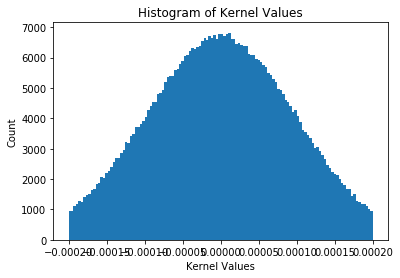

In [7]:
plot_histogram(numpy_tensor, "Histogram of Kernel Values", "Kernel Values")

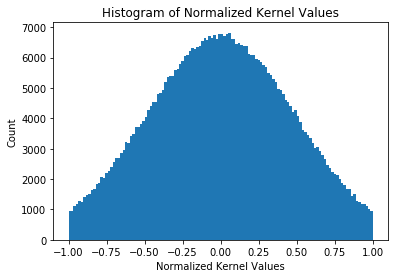

In [8]:
plot_histogram(numpy_tensor_normalized, "Histogram of Normalized Kernel Values", "Normalized Kernel Values")

In [9]:
def hypertune(thresholds, quantize_func):
  correct_percents = []
  numpy_tensors = []
  for t in thresholds:
    result = evaluate(t, quantize_func)
    correct_percents.append(result[0])
    numpy_tensors.append(result[1:])
  return correct_percents, numpy_tensors

num_points = 11

In [10]:
minmax_thresholds = [1-(0.1)*i for i in range(num_points)]
minmax_percents, minmax_tensors = hypertune(minmax_thresholds, minmax)

INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  2.96330381e-06  -9.91702327e-05  -1.29399938e-04 ...,  -4.61678392e-05
    -5.00045535e-05  -1.42035642e-04]
  [  5.53945065e-05   1.28187050e-04  -4.23281854e-05 ...,   4.28022577e-06
     4.41012089e-05   3.50486844e-05]
  [ -5.96813479e-05   1.43466081e-04  -1.20608092e-05 ...,  -8.55579856e-05
     1.47980818e-05   4.94445994e-05]
  ..., 
  [  1.16857453e-04  -6.28028138e-05   1.15255782e-04 ...,  -2.05023989e-05
    -1.94532531e-05  -6.80211160e-05]
  [ -3.56529927e-05  -3.90662535e-05   4.96086141e-05 ...,   3.92576148e-05
     1.81467578e-04  -8.71493194e-06]
  [  1.54877664e-04   1.65698464e-06   1.58678769e-04 ...,  -3.83212246e-05
     4.40519725e-05   5.71989804e-05]]

 [[  7.66989178e-05   8.20085115e-05   4.95944296e-05 ...,  -8.11152131e-05
    -4.81227507e-05  -1.94111872e-05]
  [  1.44362479e-04   1.14134156e-04  -1.14745148e-04 ...,   1.39320891e-05
     7.27848310e-05   1.88598297e-05]
  

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.207s misc: 0.010s
im_detect: 2/100 im_read: 0.030s detect: 0.157s misc: 0.010s
im_detect: 3/100 im_read: 0.030s detect: 0.142s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.135s misc: 0.010s
im_detect: 5/100 im_read: 0.031s detect: 0.130s misc: 0.010s
im_detect: 6/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 7/100 im_read: 0.031s detect: 0.125s misc: 0.010s
im_detect: 8/100 im_read: 0.031s detect: 0.123s misc: 0.010s
im_detect: 9/100 im_read: 0.031s detect: 0.122s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.121s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.120s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.119s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.118s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.118s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  1.38932664e-04   1.07772430e-04   3.55983284e-05 ...,  -5.08520243e-05
     8.22909806e-06  -1.09713015e-04]
  [  1.16234405e-04   1.78380302e-04   1.15539915e-04 ...,  -4.88976511e-05
    -7.75603621e-06  -3.85568783e-05]
  [ -1.77254333e-04  -5.36708394e-05   1.46652688e-04 ...,  -5.74785045e-05
     1.04934836e-04   7.38345698e-05]
  ..., 
  [ -1.25704726e-04  -1.55461734e-04  -1.26041996e-04 ...,  -9.00467858e-05
     6.18259082e-06  -3.31787778e-05]
  [ -7.16548311e-05   6.23454471e-05   1.11644025e-04 ...,  -6.92018293e-05
     9.71077025e-05  -9.68576569e-05]
  [  1.48338964e-04  -9.62508875e-06   1.20681209e-04 ...,   4.57409296e-05
    -5.36146035e-05   6.92868489e-05]]

 [[ -7.74535147e-05  -5.06064825e-05   1.92748830e-05 ...,   1.70148778e-04
    -1.31525128e-04  -9.34

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.202s misc: 0.010s
im_detect: 2/100 im_read: 0.031s detect: 0.154s misc: 0.010s
im_detect: 3/100 im_read: 0.031s detect: 0.137s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.131s misc: 0.010s
im_detect: 5/100 im_read: 0.033s detect: 0.127s misc: 0.010s
im_detect: 6/100 im_read: 0.033s detect: 0.122s misc: 0.010s
im_detect: 7/100 im_read: 0.033s detect: 0.121s misc: 0.010s
im_detect: 8/100 im_read: 0.033s detect: 0.119s misc: 0.010s
im_detect: 9/100 im_read: 0.033s detect: 0.118s misc: 0.010s
im_detect: 10/100 im_read: 0.033s detect: 0.117s misc: 0.010s
im_detect: 11/100 im_read: 0.033s detect: 0.116s misc: 0.010s
im_detect: 12/100 im_read: 0.033s detect: 0.115s misc: 0.010s
im_detect: 13/100 im_read: 0.033s detect: 0.114s misc: 0.010s
im_detect: 14/100 im_read: 0.033s detect: 0.114s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.23200167e-04  -6.44747561e-05   1.41664292e-04 ...,   4.91371866e-05
    -1.78408838e-04   9.84962098e-05]
  [  3.38705358e-05  -3.81110694e-05  -7.01773897e-05 ...,  -3.84060368e-05
    -9.47921653e-05   1.47586461e-05]
  [ -2.48860324e-05   3.18635102e-05  -1.03953316e-05 ...,  -4.73377222e-05
    -5.13881387e-05  -1.35582559e-05]
  ..., 
  [ -1.94340300e-05   1.35998867e-04   4.82479300e-06 ...,  -1.35967988e-04
     1.00444704e-05   9.39700258e-05]
  [  9.02613319e-05  -2.80021995e-05  -1.96546986e-04 ...,  -2.13472904e-05
     8.87002716e-06  -1.14608101e-05]
  [ -5.55961960e-05   5.97310645e-05   1.35531227e-04 ...,  -3.36311932e-05
     1.21233570e-04  -8.43130329e-05]]

 [[  7.51871339e-05  -1.88860125e-04   1.44157806e-04 ...,   5.44124523e-05
    -3.31486990e-05  -6.87

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.033s detect: 0.204s misc: 0.010s
im_detect: 2/100 im_read: 0.032s detect: 0.155s misc: 0.010s
im_detect: 3/100 im_read: 0.032s detect: 0.140s misc: 0.010s
im_detect: 4/100 im_read: 0.032s detect: 0.133s misc: 0.010s
im_detect: 5/100 im_read: 0.032s detect: 0.129s misc: 0.010s
im_detect: 6/100 im_read: 0.032s detect: 0.125s misc: 0.010s
im_detect: 7/100 im_read: 0.032s detect: 0.124s misc: 0.010s
im_detect: 8/100 im_read: 0.032s detect: 0.122s misc: 0.010s
im_detect: 9/100 im_read: 0.032s detect: 0.121s misc: 0.010s
im_detect: 10/100 im_read: 0.032s detect: 0.119s misc: 0.010s
im_detect: 11/100 im_read: 0.032s detect: 0.118s misc: 0.010s
im_detect: 12/100 im_read: 0.032s detect: 0.117s misc: 0.010s
im_detect: 13/100 im_read: 0.032s detect: 0.116s misc: 0.010s
im_detect: 14/100 im_read: 0.032s detect: 0.115s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.06046507e-04  -6.02332111e-05   1.19549724e-04 ...,   7.92476058e-05
     7.24931451e-05   1.04468796e-04]
  [  6.67352215e-05   5.31014593e-05   5.78983636e-05 ...,   1.25493243e-04
     1.08654975e-04   1.62342913e-04]
  [  6.14263554e-05   3.36732846e-05  -2.05293363e-05 ...,   6.30679933e-05
    -1.28513770e-04   1.14106675e-04]
  ..., 
  [ -1.60522577e-05   7.23596895e-05   1.12047477e-04 ...,  -9.81709745e-05
    -9.50851972e-05  -7.54524663e-05]
  [  4.10585126e-05   7.81141935e-05  -6.09974304e-05 ...,  -1.64384292e-05
     1.05290419e-04  -3.02165536e-05]
  [ -4.44452853e-05  -6.71823727e-05   9.69760731e-05 ...,   4.63737433e-06
     7.46900478e-05   9.19508166e-05]]

 [[  1.90618390e-04  -4.17957199e-06   1.11134359e-04 ...,   9.65054642e-05
    -1.30630448e-04  -1.06

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.032s detect: 0.209s misc: 0.010s
im_detect: 2/100 im_read: 0.032s detect: 0.159s misc: 0.010s
im_detect: 3/100 im_read: 0.032s detect: 0.143s misc: 0.010s
im_detect: 4/100 im_read: 0.032s detect: 0.133s misc: 0.010s
im_detect: 5/100 im_read: 0.032s detect: 0.129s misc: 0.010s
im_detect: 6/100 im_read: 0.032s detect: 0.126s misc: 0.010s
im_detect: 7/100 im_read: 0.032s detect: 0.122s misc: 0.010s
im_detect: 8/100 im_read: 0.032s detect: 0.120s misc: 0.010s
im_detect: 9/100 im_read: 0.032s detect: 0.119s misc: 0.010s
im_detect: 10/100 im_read: 0.032s detect: 0.119s misc: 0.010s
im_detect: 11/100 im_read: 0.032s detect: 0.118s misc: 0.010s
im_detect: 12/100 im_read: 0.032s detect: 0.116s misc: 0.010s
im_detect: 13/100 im_read: 0.032s detect: 0.116s misc: 0.010s
im_detect: 14/100 im_read: 0.032s detect: 0.115s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.23002537e-04  -5.37532906e-05   9.68988461e-05 ...,   6.46384797e-05
     7.43745913e-05  -4.83557851e-05]
  [ -1.68355138e-04   5.76633865e-05  -3.59878904e-05 ...,   1.71793745e-05
    -1.63342629e-05  -3.63820909e-05]
  [ -8.74272519e-05  -5.68811884e-05   5.54419457e-05 ...,   7.69128892e-05
    -1.11772977e-04   1.35425144e-04]
  ..., 
  [ -2.74504760e-06   1.05298612e-04   1.73917724e-04 ...,   1.34618429e-04
     1.76796879e-04  -6.26021501e-05]
  [  4.59084949e-05  -4.69052866e-05  -1.82039821e-05 ...,  -1.80459712e-04
     1.97328318e-05  -1.04829240e-04]
  [ -1.34402828e-04  -1.37550916e-04  -9.78794851e-05 ...,  -3.98715638e-05
    -8.28902557e-05   5.27369484e-05]]

 [[ -4.27047162e-05  -4.18620511e-05  -9.91716588e-05 ...,   3.78006189e-05
    -4.96252833e-05   3.14

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.200s misc: 0.015s
im_detect: 2/100 im_read: 0.032s detect: 0.157s misc: 0.015s
im_detect: 3/100 im_read: 0.032s detect: 0.141s misc: 0.014s
im_detect: 4/100 im_read: 0.032s detect: 0.133s misc: 0.014s
im_detect: 5/100 im_read: 0.032s detect: 0.127s misc: 0.014s
im_detect: 6/100 im_read: 0.032s detect: 0.124s misc: 0.014s
im_detect: 7/100 im_read: 0.032s detect: 0.121s misc: 0.014s
im_detect: 8/100 im_read: 0.059s detect: 0.120s misc: 0.014s
im_detect: 9/100 im_read: 0.056s detect: 0.118s misc: 0.014s
im_detect: 10/100 im_read: 0.054s detect: 0.117s misc: 0.014s
im_detect: 11/100 im_read: 0.051s detect: 0.116s misc: 0.014s
im_detect: 12/100 im_read: 0.050s detect: 0.115s misc: 0.014s
im_detect: 13/100 im_read: 0.048s detect: 0.114s misc: 0.014s
im_detect: 14/100 im_read: 0.047s detect: 0.114s misc: 0.014s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.05412233e-04   9.40885147e-05   6.69586711e-07 ...,  -8.75579008e-06
    -4.21558440e-07  -1.42991252e-04]
  [ -1.21958488e-04  -5.32657323e-05   7.78953327e-05 ...,  -1.46371356e-04
    -1.66038764e-04  -4.35262446e-05]
  [  4.52578352e-05  -5.25283504e-05  -1.15061062e-04 ...,   3.89531051e-05
     4.24993777e-05  -1.65545440e-04]
  ..., 
  [ -1.23351027e-04   1.11593574e-04  -1.71121676e-04 ...,   1.32811456e-05
    -7.17971925e-05   9.75373696e-05]
  [  2.82747260e-05   1.18362615e-04  -4.77129324e-05 ...,   1.20706194e-04
    -6.62052553e-05  -7.14224007e-05]
  [ -1.77740949e-04   2.93611101e-05  -3.51668750e-05 ...,  -8.52100493e-05
     6.02967193e-05   7.08780181e-06]]

 [[  2.53774069e-05   6.94079972e-06   5.77112005e-05 ...,  -1.53129629e-04
     8.25799434e-05  -2.83

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.198s misc: 0.016s
im_detect: 2/100 im_read: 0.031s detect: 0.156s misc: 0.017s
im_detect: 3/100 im_read: 0.031s detect: 0.139s misc: 0.016s
im_detect: 4/100 im_read: 0.031s detect: 0.131s misc: 0.016s
im_detect: 5/100 im_read: 0.031s detect: 0.127s misc: 0.016s
im_detect: 6/100 im_read: 0.031s detect: 0.123s misc: 0.016s
im_detect: 7/100 im_read: 0.031s detect: 0.122s misc: 0.016s
im_detect: 8/100 im_read: 0.031s detect: 0.120s misc: 0.016s
im_detect: 9/100 im_read: 0.031s detect: 0.118s misc: 0.016s
im_detect: 10/100 im_read: 0.031s detect: 0.118s misc: 0.016s
im_detect: 11/100 im_read: 0.031s detect: 0.117s misc: 0.016s
im_detect: 12/100 im_read: 0.031s detect: 0.116s misc: 0.016s
im_detect: 13/100 im_read: 0.031s detect: 0.115s misc: 0.016s
im_detect: 14/100 im_read: 0.031s detect: 0.115s misc: 0.016s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  3.17184204e-05   9.77326781e-05   5.64701659e-05 ...,  -9.39232777e-05
    -3.58444231e-05  -9.42511979e-05]
  [  4.61762284e-05  -8.39222557e-05  -4.96874554e-06 ...,   4.58986415e-06
     4.10107496e-05  -1.61005682e-05]
  [ -1.21734476e-04  -8.08907207e-05  -3.36428675e-05 ...,  -8.60548389e-05
     5.20230824e-05  -1.64257755e-04]
  ..., 
  [ -8.65307375e-05  -9.25495697e-05   1.33302441e-04 ...,  -4.29301836e-05
     5.55361510e-07   8.97092832e-05]
  [ -6.53645693e-05   8.46241965e-05  -4.38865709e-06 ...,  -3.02919379e-05
     4.44703255e-05  -9.52702176e-05]
  [  1.33880952e-04  -9.47975932e-05  -1.24236994e-05 ...,  -1.26880506e-04
    -1.97341884e-04  -4.25392900e-05]]

 [[  7.73030188e-05  -2.48590186e-05  -4.70514824e-05 ...,   7.23008561e-05
     1.16383475e-04   9.07

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.034s detect: 0.238s misc: 0.011s
im_detect: 2/100 im_read: 0.034s detect: 0.179s misc: 0.011s
im_detect: 3/100 im_read: 0.033s detect: 0.154s misc: 0.011s
im_detect: 4/100 im_read: 0.032s detect: 0.143s misc: 0.011s
im_detect: 5/100 im_read: 0.032s detect: 0.137s misc: 0.010s
im_detect: 6/100 im_read: 0.032s detect: 0.132s misc: 0.010s
im_detect: 7/100 im_read: 0.032s detect: 0.128s misc: 0.010s
im_detect: 8/100 im_read: 0.032s detect: 0.125s misc: 0.010s
im_detect: 9/100 im_read: 0.032s detect: 0.124s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.122s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.120s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.119s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.118s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.118s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  1.83104261e-04   7.62156833e-06   5.33190941e-05 ...,  -2.34386898e-05
     1.08083521e-04   5.58956344e-06]
  [  4.86697354e-05  -1.17184711e-04   1.70565167e-04 ...,   1.62979234e-06
    -4.29790780e-05  -4.99297166e-05]
  [ -1.42469371e-05  -8.99844454e-05  -6.91470414e-05 ...,   2.30621081e-05
     2.88524025e-05  -2.84407474e-06]
  ..., 
  [ -1.54866848e-05   1.98003931e-06   1.27332742e-05 ...,  -2.11712213e-05
    -1.83984102e-05   8.52491867e-05]
  [  9.90017143e-05  -4.94270462e-05  -5.90392046e-05 ...,   6.63985338e-05
    -1.87544239e-04   9.47450244e-05]
  [  2.86856139e-05  -3.27609014e-05   1.31268398e-05 ...,   5.77029277e-05
    -2.51489723e-07  -1.67416219e-05]]

 [[  4.72686734e-05   5.70560696e-05  -1.36091097e-04 ...,  -6.35242686e-05
    -1.26849132e-04   4.08

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.207s misc: 0.011s
im_detect: 2/100 im_read: 0.031s detect: 0.158s misc: 0.011s
im_detect: 3/100 im_read: 0.031s detect: 0.143s misc: 0.011s
im_detect: 4/100 im_read: 0.031s detect: 0.134s misc: 0.011s
im_detect: 5/100 im_read: 0.031s detect: 0.128s misc: 0.011s
im_detect: 6/100 im_read: 0.032s detect: 0.126s misc: 0.011s
im_detect: 7/100 im_read: 0.032s detect: 0.122s misc: 0.011s
im_detect: 8/100 im_read: 0.032s detect: 0.121s misc: 0.011s
im_detect: 9/100 im_read: 0.032s detect: 0.119s misc: 0.011s
im_detect: 10/100 im_read: 0.032s detect: 0.118s misc: 0.011s
im_detect: 11/100 im_read: 0.032s detect: 0.117s misc: 0.011s
im_detect: 12/100 im_read: 0.032s detect: 0.116s misc: 0.011s
im_detect: 13/100 im_read: 0.032s detect: 0.116s misc: 0.011s
im_detect: 14/100 im_read: 0.032s detect: 0.116s misc: 0.011s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.35445043e-05   1.32466768e-04   2.56369440e-05 ...,   9.77881791e-05
     1.47496633e-06  -3.45989392e-05]
  [  1.30903238e-04   5.57850854e-06   1.39617754e-04 ...,  -2.45043739e-05
    -1.49319376e-05  -1.66294427e-04]
  [  1.38913209e-04  -1.47682586e-04  -6.81684905e-05 ...,   1.66646743e-04
    -4.30958426e-05  -1.68258572e-04]
  ..., 
  [  5.03721640e-05  -9.66336374e-05   7.09977394e-05 ...,   7.04285849e-05
     6.04111883e-05  -9.69587782e-05]
  [  8.14217929e-05   1.87981495e-05   1.22012207e-04 ...,  -1.40459524e-04
     9.68829263e-05   3.92043621e-05]
  [ -7.14314301e-05  -1.58543135e-05   5.46818410e-05 ...,   5.43782880e-05
     4.14297574e-05   1.73613545e-04]]

 [[  6.95295021e-05  -1.42748686e-04   1.00464487e-04 ...,  -3.82012149e-05
     1.23905949e-04  -1.05

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.205s misc: 0.015s
im_detect: 2/100 im_read: 0.032s detect: 0.156s misc: 0.015s
im_detect: 3/100 im_read: 0.032s detect: 0.140s misc: 0.015s
im_detect: 4/100 im_read: 0.032s detect: 0.132s misc: 0.015s
im_detect: 5/100 im_read: 0.032s detect: 0.126s misc: 0.015s
im_detect: 6/100 im_read: 0.032s detect: 0.123s misc: 0.015s
im_detect: 7/100 im_read: 0.032s detect: 0.120s misc: 0.015s
im_detect: 8/100 im_read: 0.032s detect: 0.118s misc: 0.015s
im_detect: 9/100 im_read: 0.033s detect: 0.117s misc: 0.015s
im_detect: 10/100 im_read: 0.033s detect: 0.116s misc: 0.015s
im_detect: 11/100 im_read: 0.033s detect: 0.115s misc: 0.015s
im_detect: 12/100 im_read: 0.033s detect: 0.115s misc: 0.015s
im_detect: 13/100 im_read: 0.033s detect: 0.114s misc: 0.015s
im_detect: 14/100 im_read: 0.033s detect: 0.114s misc: 0.015s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  6.87147985e-05  -9.87782114e-05   1.14429713e-04 ...,   5.69390286e-05
    -1.00051278e-04  -1.38394855e-04]
  [ -5.94515359e-06   6.18158520e-05  -9.49051173e-06 ...,  -2.50523553e-05
     1.51824979e-05   1.44779493e-04]
  [ -1.46713646e-04  -1.37919953e-04   4.15820614e-05 ...,   1.13898488e-04
     3.21016050e-05   5.60034605e-05]
  ..., 
  [ -2.07645917e-05  -1.54761787e-04   4.75941624e-06 ...,  -4.93979933e-05
     2.93364465e-05   1.06084008e-04]
  [  5.72483768e-05   9.99907134e-05   6.55718541e-05 ...,  -7.44501767e-06
     1.64662080e-04  -3.15866710e-05]
  [  4.02685328e-05   6.36757686e-05  -1.77648442e-04 ...,  -9.76102569e-07
     1.17711592e-04  -9.44311687e-05]]

 [[  3.01903292e-05   3.44043947e-05   1.46771490e-04 ...,  -1.42997727e-04
    -1.00250661e-04  -1.37

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.033s detect: 0.201s misc: 0.010s
im_detect: 2/100 im_read: 0.033s detect: 0.156s misc: 0.010s
im_detect: 3/100 im_read: 0.033s detect: 0.140s misc: 0.010s
im_detect: 4/100 im_read: 0.033s detect: 0.132s misc: 0.010s
im_detect: 5/100 im_read: 0.033s detect: 0.126s misc: 0.010s
im_detect: 6/100 im_read: 0.033s detect: 0.123s misc: 0.010s
im_detect: 7/100 im_read: 0.033s detect: 0.120s misc: 0.010s
im_detect: 8/100 im_read: 0.033s detect: 0.118s misc: 0.010s
im_detect: 9/100 im_read: 0.033s detect: 0.117s misc: 0.010s
im_detect: 10/100 im_read: 0.033s detect: 0.116s misc: 0.010s
im_detect: 11/100 im_read: 0.033s detect: 0.115s misc: 0.010s
im_detect: 12/100 im_read: 0.033s detect: 0.114s misc: 0.010s
im_detect: 13/100 im_read: 0.033s detect: 0.114s misc: 0.010s
im_detect: 14/100 im_read: 0.033s detect: 0.114s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -8.53808306e-05  -1.22440615e-04   3.75632044e-05 ...,  -4.56939561e-05
     1.24413054e-06  -1.05780811e-04]
  [  7.97757239e-05   1.95370631e-05   5.86554379e-05 ...,   7.20366661e-05
     8.81236992e-05   4.76757887e-05]
  [ -1.48668521e-04  -1.31052308e-04   8.04138472e-05 ...,  -9.32133407e-05
     1.33699534e-04  -1.67416409e-04]
  ..., 
  [ -1.20426012e-04   9.14554839e-05   2.69291868e-05 ...,  -6.49997601e-05
    -2.53572580e-05  -1.08937558e-04]
  [  2.11925199e-05   6.97880459e-05  -1.47580315e-04 ...,   8.72453456e-05
    -6.88723821e-06  -2.07657340e-05]
  [  9.05534689e-05   7.69133912e-05   1.38031581e-04 ...,  -2.82899855e-05
     9.19785816e-06   7.05951152e-06]]

 [[ -1.35817063e-05   7.91425919e-05  -8.00591297e-05 ...,   5.68995420e-05
    -1.26724376e-06   8.90

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.029s detect: 0.205s misc: 0.011s
im_detect: 2/100 im_read: 0.032s detect: 0.156s misc: 0.010s
im_detect: 3/100 im_read: 0.031s detect: 0.140s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.133s misc: 0.010s
im_detect: 5/100 im_read: 0.031s detect: 0.126s misc: 0.010s
im_detect: 6/100 im_read: 0.031s detect: 0.124s misc: 0.010s
im_detect: 7/100 im_read: 0.031s detect: 0.121s misc: 0.010s
im_detect: 8/100 im_read: 0.031s detect: 0.120s misc: 0.010s
im_detect: 9/100 im_read: 0.031s detect: 0.118s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.117s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.116s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.116s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.115s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.114s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.


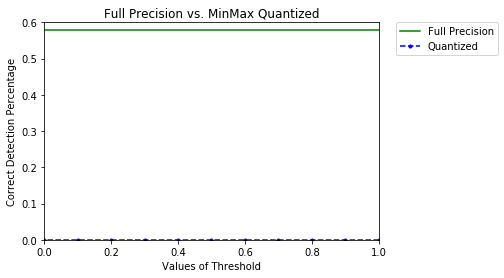

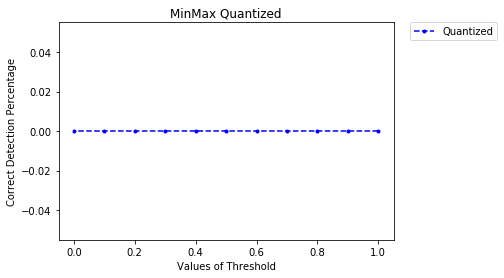

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
plot_percents("Full Precision vs. MinMax Quantized", minmax_thresholds, minmax_percents, True)
plot_percents("MinMax Quantized", minmax_thresholds, minmax_percents, False)
print(minmax_percents)

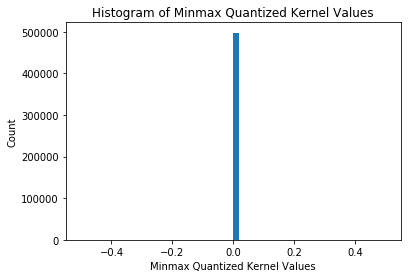

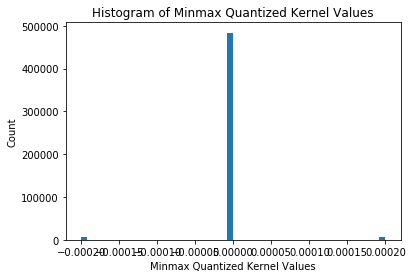

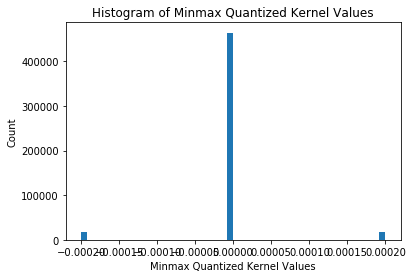

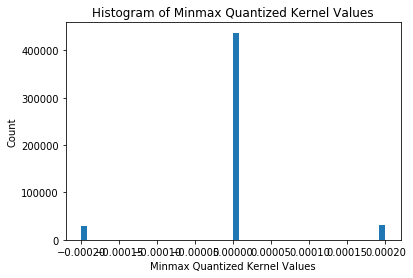

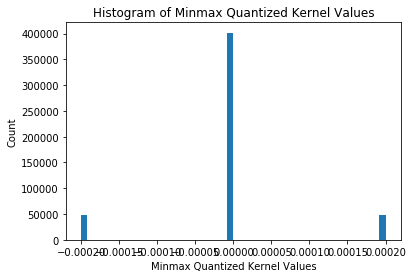

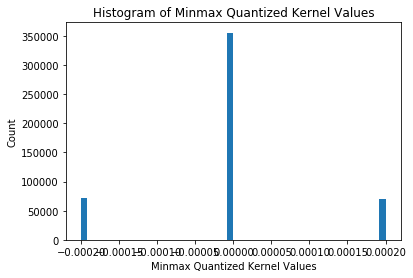

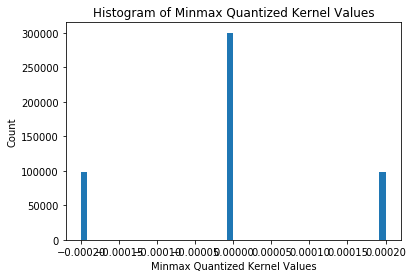

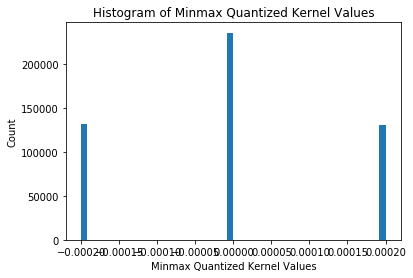

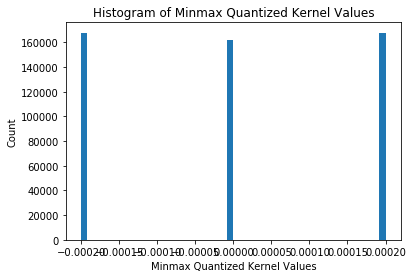

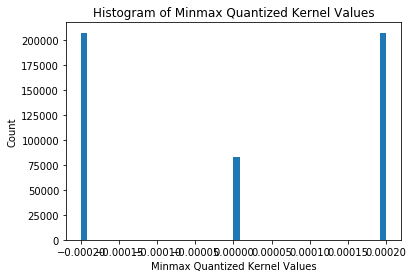

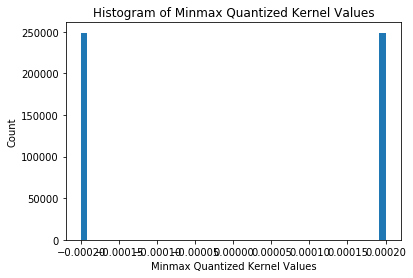

In [12]:
for i in range(num_points):
  plot_histogram(minmax_tensors[i][2], "Histogram of Minmax Quantized Kernel Values", "Minmax Quantized Kernel Values", 50)

In [13]:
std1_thresholds = [1-(0.1)*i for i in range(num_points)]
std1_percents, std1_tensors = hypertune(std1_thresholds, std1)

INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -8.09237608e-05  -1.36883900e-04   9.51089532e-05 ...,  -1.76853908e-04
     4.22813036e-06  -9.14113771e-05]
  [ -1.67564103e-05  -7.08235984e-06   6.97476644e-05 ...,   1.71914755e-04
    -4.46558042e-05  -2.36680116e-05]
  [  4.42025976e-06  -5.57179010e-05   1.20916200e-04 ...,  -5.14607418e-05
     3.44469663e-05  -9.09240844e-05]
  ..., 
  [ -6.75968113e-05   3.92000693e-05  -1.76960093e-05 ...,   1.42673030e-04
     4.66093188e-05   3.74555711e-05]
  [ -6.00467320e-05   1.82305412e-05   5.42242160e-05 ...,   1.59910014e-05
     1.12760412e-04  -1.36619121e-06]
  [ -9.04364788e-06  -1.56933038e-05  -1.14983195e-04 ...,   1.69092775e-04
     8.91253731e-05  -3.07019072e-05]]

 [[ -8.50998331e-05  -1.78876107e-05  -4.57581991e-05 ...,  -6.01779211e-05
     4.57160968e-05  -6.55854383e-05]
  [ -9.07641006e-05  -1.70268140e-05   4.33440728e-05 ...,   1.77203328e-04
    -2.30218370e-06  -1.18264943e-04]
  

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.035s detect: 0.216s misc: 0.010s
im_detect: 2/100 im_read: 0.033s detect: 0.167s misc: 0.010s
im_detect: 3/100 im_read: 0.032s detect: 0.150s misc: 0.010s
im_detect: 4/100 im_read: 0.032s detect: 0.141s misc: 0.010s
im_detect: 5/100 im_read: 0.032s detect: 0.137s misc: 0.010s
im_detect: 6/100 im_read: 0.032s detect: 0.133s misc: 0.010s
im_detect: 7/100 im_read: 0.032s detect: 0.131s misc: 0.010s
im_detect: 8/100 im_read: 0.032s detect: 0.130s misc: 0.010s
im_detect: 9/100 im_read: 0.032s detect: 0.128s misc: 0.010s
im_detect: 10/100 im_read: 0.032s detect: 0.127s misc: 0.010s
im_detect: 11/100 im_read: 0.032s detect: 0.126s misc: 0.010s
im_detect: 12/100 im_read: 0.032s detect: 0.125s misc: 0.010s
im_detect: 13/100 im_read: 0.032s detect: 0.124s misc: 0.010s
im_detect: 14/100 im_read: 0.032s detect: 0.124s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  2.12501782e-05   1.72363543e-05  -1.80019470e-05 ...,  -1.70272804e-04
    -3.88300541e-05   1.48359715e-04]
  [ -2.66069546e-05   2.68128679e-05  -4.62756398e-05 ...,  -1.32757035e-04
     8.78454921e-06  -9.57399752e-05]
  [ -5.84132285e-05   6.97726500e-05  -8.43425296e-05 ...,  -3.14753051e-05
    -1.42801960e-04   2.12860177e-05]
  ..., 
  [  4.46980739e-05  -4.52689019e-05  -5.67202660e-05 ...,   7.16400828e-05
    -1.62706092e-05  -5.58267820e-05]
  [ -1.46784980e-04   8.73894169e-05  -7.13710397e-05 ...,  -5.95075653e-05
    -1.07703359e-04   8.64073518e-05]
  [ -6.32968840e-06  -5.12821316e-05  -1.75006098e-05 ...,   1.17229021e-04
     3.53481810e-05   1.23400241e-05]]

 [[  1.51559769e-04   4.88891419e-05  -6.77116041e-05 ...,  -3.44296095e-05
     4.29711645e-06   5.60

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.220s misc: 0.010s
im_detect: 2/100 im_read: 0.031s detect: 0.168s misc: 0.010s
im_detect: 3/100 im_read: 0.031s detect: 0.152s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.143s misc: 0.010s
im_detect: 5/100 im_read: 0.031s detect: 0.138s misc: 0.010s
im_detect: 6/100 im_read: 0.032s detect: 0.135s misc: 0.010s
im_detect: 7/100 im_read: 0.032s detect: 0.131s misc: 0.010s
im_detect: 8/100 im_read: 0.031s detect: 0.129s misc: 0.010s
im_detect: 9/100 im_read: 0.031s detect: 0.128s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.126s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.125s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.124s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.90271618e-04  -6.34731841e-05  -1.39012045e-04 ...,   1.72568743e-05
    -1.74879879e-05   1.33546899e-04]
  [  9.60688412e-05  -9.22562103e-05   1.31686742e-04 ...,  -6.77841235e-05
     1.11668538e-04  -6.59964935e-05]
  [ -7.21826018e-06   5.93456207e-05   9.63949424e-06 ...,   3.41230771e-05
    -1.20529066e-05  -7.33981360e-05]
  ..., 
  [ -3.87753498e-05  -7.48287057e-05  -6.59064199e-06 ...,   7.06906067e-05
     4.25131257e-05  -3.12329030e-05]
  [  1.27555526e-04  -3.06470320e-05  -3.31717674e-05 ...,   1.19683391e-04
     2.98043392e-06  -3.11984550e-05]
  [ -1.22813886e-04   3.42118983e-05  -5.14109888e-06 ...,  -3.02928493e-06
    -1.16527663e-04  -1.54731351e-05]]

 [[ -8.52869562e-05  -1.73745520e-05  -3.32984455e-05 ...,  -1.10316570e-04
     2.32068705e-05   9.59

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.221s misc: 0.010s
im_detect: 2/100 im_read: 0.031s detect: 0.165s misc: 0.010s
im_detect: 3/100 im_read: 0.031s detect: 0.147s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.140s misc: 0.010s
im_detect: 5/100 im_read: 0.031s detect: 0.136s misc: 0.010s
im_detect: 6/100 im_read: 0.031s detect: 0.132s misc: 0.010s
im_detect: 7/100 im_read: 0.031s detect: 0.129s misc: 0.010s
im_detect: 8/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 9/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.126s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.125s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.125s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.124s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.123s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  7.19645004e-06  -6.45641703e-05  -6.95330018e-05 ...,   8.56182814e-05
     1.34321861e-04   5.56122395e-05]
  [  2.71319586e-05   5.80950436e-05   2.86026316e-05 ...,  -2.50416397e-05
     7.99338886e-05  -1.09337336e-04]
  [  7.64724682e-05  -1.56997907e-04  -7.74100336e-05 ...,  -9.34542841e-05
    -3.28435090e-05   1.25661303e-04]
  ..., 
  [  1.20602643e-04   1.94495457e-04  -5.89475749e-05 ...,  -1.00640296e-04
     1.92919440e-04   5.04246709e-05]
  [  6.25944449e-05  -6.47485922e-06  -9.22603140e-05 ...,  -4.18012860e-05
    -5.74229889e-05   3.29182185e-05]
  [  1.02396487e-04   1.89093174e-04   3.23640488e-05 ...,   4.60657648e-05
    -3.80774909e-05   1.06487532e-04]]

 [[ -2.22996478e-05   1.96003777e-04   8.35783794e-05 ...,   1.12974976e-05
    -9.75623334e-05   5.86

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.029s detect: 0.217s misc: 0.010s
im_detect: 2/100 im_read: 0.031s detect: 0.163s misc: 0.010s
im_detect: 3/100 im_read: 0.031s detect: 0.147s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.139s misc: 0.010s
im_detect: 5/100 im_read: 0.031s detect: 0.135s misc: 0.010s
im_detect: 6/100 im_read: 0.031s detect: 0.132s misc: 0.010s
im_detect: 7/100 im_read: 0.031s detect: 0.130s misc: 0.010s
im_detect: 8/100 im_read: 0.031s detect: 0.128s misc: 0.010s
im_detect: 9/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.126s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.125s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.124s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.123s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.123s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  1.39020878e-04   5.98708248e-05  -8.63467503e-05 ...,   5.14148087e-05
     1.28682848e-04   9.96652398e-06]
  [  8.46849871e-05  -1.94555673e-06  -3.27685957e-05 ...,   1.72290340e-04
    -6.31005387e-05  -8.89509683e-05]
  [ -3.94761373e-05  -1.06951040e-04   9.43624837e-05 ...,  -9.58414385e-05
    -8.34821185e-05   1.76913207e-04]
  ..., 
  [  1.89895036e-05   1.12745234e-04   1.12389898e-04 ...,  -5.75174672e-05
    -6.68162247e-05   1.49703323e-04]
  [ -9.74581999e-05   1.42549121e-04  -1.05864056e-04 ...,   1.35507607e-05
     1.89320654e-05  -1.35507158e-04]
  [  1.22095016e-05   3.31768342e-06  -5.61977831e-05 ...,   7.15685674e-05
    -1.96437948e-04  -1.56710521e-04]]

 [[  3.47146779e-05  -1.17170297e-04  -1.54609079e-04 ...,  -1.17331678e-04
    -1.94931890e-05   8.24

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.034s detect: 0.217s misc: 0.014s
im_detect: 2/100 im_read: 0.033s detect: 0.169s misc: 0.014s
im_detect: 3/100 im_read: 0.035s detect: 0.152s misc: 0.014s
im_detect: 4/100 im_read: 0.034s detect: 0.142s misc: 0.014s
im_detect: 5/100 im_read: 0.033s detect: 0.139s misc: 0.014s
im_detect: 6/100 im_read: 0.033s detect: 0.135s misc: 0.014s
im_detect: 7/100 im_read: 0.033s detect: 0.131s misc: 0.014s
im_detect: 8/100 im_read: 0.033s detect: 0.129s misc: 0.014s
im_detect: 9/100 im_read: 0.033s detect: 0.128s misc: 0.014s
im_detect: 10/100 im_read: 0.033s detect: 0.127s misc: 0.014s
im_detect: 11/100 im_read: 0.033s detect: 0.126s misc: 0.014s
im_detect: 12/100 im_read: 0.033s detect: 0.125s misc: 0.014s
im_detect: 13/100 im_read: 0.033s detect: 0.124s misc: 0.014s
im_detect: 14/100 im_read: 0.032s detect: 0.123s misc: 0.014s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  3.61842685e-05  -4.30939908e-05   1.66383441e-04 ...,   2.93849644e-05
    -1.30158051e-05   9.78982789e-05]
  [ -3.09889856e-06   5.55140286e-05  -5.27158118e-05 ...,  -5.89120500e-05
    -8.08812692e-05  -2.98025388e-05]
  [  5.00387760e-05  -1.60548545e-04   7.49696919e-05 ...,  -5.74767146e-05
    -2.27811615e-05  -7.93663785e-05]
  ..., 
  [ -9.30541210e-05  -1.17927069e-04   1.83689990e-04 ...,   1.48294363e-04
     2.36935284e-05   5.06671131e-06]
  [  9.62844424e-05   2.18809328e-05  -4.92488653e-05 ...,  -6.35857486e-06
    -4.65590601e-05  -1.11440910e-04]
  [ -5.40399669e-05  -3.67711036e-05   1.02896520e-04 ...,   5.10021937e-06
     1.16186828e-04  -8.93196848e-05]]

 [[  1.31571069e-04   1.77442766e-04   1.25074905e-04 ...,  -2.33801693e-05
     1.18979260e-05   1.14

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.221s misc: 0.016s
im_detect: 2/100 im_read: 0.031s detect: 0.167s misc: 0.016s
im_detect: 3/100 im_read: 0.031s detect: 0.151s misc: 0.016s
im_detect: 4/100 im_read: 0.031s detect: 0.142s misc: 0.016s
im_detect: 5/100 im_read: 0.031s detect: 0.138s misc: 0.016s
im_detect: 6/100 im_read: 0.031s detect: 0.135s misc: 0.016s
im_detect: 7/100 im_read: 0.031s detect: 0.133s misc: 0.016s
im_detect: 8/100 im_read: 0.031s detect: 0.131s misc: 0.016s
im_detect: 9/100 im_read: 0.031s detect: 0.129s misc: 0.016s
im_detect: 10/100 im_read: 0.031s detect: 0.128s misc: 0.016s
im_detect: 11/100 im_read: 0.031s detect: 0.127s misc: 0.016s
im_detect: 12/100 im_read: 0.031s detect: 0.126s misc: 0.016s
im_detect: 13/100 im_read: 0.031s detect: 0.125s misc: 0.016s
im_detect: 14/100 im_read: 0.031s detect: 0.124s misc: 0.016s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -2.44220082e-05  -1.04140730e-04  -7.74188302e-05 ...,   1.07232881e-04
     3.67764223e-05  -3.86869760e-05]
  [ -3.95283723e-06   1.79720682e-05  -7.18672766e-07 ...,  -1.21982703e-05
    -5.98142542e-05   1.07602675e-04]
  [ -1.61573364e-04  -1.41533921e-04   9.00767100e-06 ...,  -1.23234291e-04
    -8.60957061e-06   3.04175646e-05]
  ..., 
  [  2.35279094e-05   1.27231207e-04   1.40242686e-04 ...,   2.69690486e-06
     1.29200605e-04  -5.57127123e-07]
  [ -9.60948310e-05  -3.05502690e-05   7.83191499e-05 ...,  -7.39141979e-05
    -7.26625658e-05  -8.78610153e-05]
  [  1.50530919e-04   4.29275387e-05  -1.02222621e-04 ...,  -1.79587805e-05
     1.11238594e-04   1.04787410e-04]]

 [[  6.09983326e-05  -3.67342946e-05  -1.12366914e-04 ...,   9.26709690e-05
    -8.72174951e-06   6.26

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.217s misc: 0.017s
im_detect: 2/100 im_read: 0.031s detect: 0.168s misc: 0.017s
im_detect: 3/100 im_read: 0.031s detect: 0.150s misc: 0.016s
im_detect: 4/100 im_read: 0.031s detect: 0.139s misc: 0.016s
im_detect: 5/100 im_read: 0.031s detect: 0.134s misc: 0.017s
im_detect: 6/100 im_read: 0.031s detect: 0.130s misc: 0.016s
im_detect: 7/100 im_read: 0.031s detect: 0.128s misc: 0.016s
im_detect: 8/100 im_read: 0.031s detect: 0.126s misc: 0.016s
im_detect: 9/100 im_read: 0.031s detect: 0.125s misc: 0.016s
im_detect: 10/100 im_read: 0.031s detect: 0.123s misc: 0.016s
im_detect: 11/100 im_read: 0.031s detect: 0.123s misc: 0.016s
im_detect: 12/100 im_read: 0.031s detect: 0.122s misc: 0.016s
im_detect: 13/100 im_read: 0.031s detect: 0.121s misc: 0.016s
im_detect: 14/100 im_read: 0.031s detect: 0.121s misc: 0.016s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  7.77628302e-05  -1.32269517e-04   1.52602981e-04 ...,  -1.11608337e-04
    -4.49433865e-05   5.68429095e-05]
  [  3.20688960e-05   4.53355597e-06   9.47691078e-05 ...,   3.91666254e-05
     6.60661826e-05  -1.63125398e-04]
  [ -5.73259204e-05  -1.53690726e-05   4.76413625e-05 ...,  -1.89128375e-04
     2.46216005e-05   5.04504860e-05]
  ..., 
  [ -1.07288099e-04  -5.53738755e-05  -1.39457959e-04 ...,   8.27141484e-05
    -1.52631328e-05  -7.66683952e-05]
  [ -3.43471365e-05  -9.62590129e-05   1.01438040e-04 ...,   8.01289207e-05
    -2.76154278e-05  -1.54528680e-05]
  [ -1.44444697e-04  -2.64155296e-05  -6.62893945e-05 ...,  -2.70751625e-05
     9.91870183e-06  -5.13844607e-05]]

 [[  7.10043678e-05  -7.66742087e-05  -9.67584056e-05 ...,   7.10495297e-05
     1.31800261e-04  -7.82

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.029s detect: 0.220s misc: 0.016s
im_detect: 2/100 im_read: 0.030s detect: 0.168s misc: 0.016s
im_detect: 3/100 im_read: 0.034s detect: 0.150s misc: 0.016s
im_detect: 4/100 im_read: 0.033s detect: 0.141s misc: 0.016s
im_detect: 5/100 im_read: 0.033s detect: 0.136s misc: 0.016s
im_detect: 6/100 im_read: 0.033s detect: 0.132s misc: 0.016s
im_detect: 7/100 im_read: 0.032s detect: 0.130s misc: 0.016s
im_detect: 8/100 im_read: 0.032s detect: 0.129s misc: 0.016s
im_detect: 9/100 im_read: 0.032s detect: 0.127s misc: 0.016s
im_detect: 10/100 im_read: 0.032s detect: 0.126s misc: 0.016s
im_detect: 11/100 im_read: 0.032s detect: 0.125s misc: 0.016s
im_detect: 12/100 im_read: 0.032s detect: 0.124s misc: 0.016s
im_detect: 13/100 im_read: 0.032s detect: 0.124s misc: 0.016s
im_detect: 14/100 im_read: 0.032s detect: 0.123s misc: 0.016s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -2.98051327e-05  -1.99042581e-04   4.01558682e-05 ...,  -1.67654398e-05
    -1.30833563e-04  -7.14769631e-05]
  [ -6.96723464e-06   3.50834125e-05  -1.47236700e-04 ...,  -6.90862435e-05
    -1.27913096e-04   1.13535871e-05]
  [  3.65535052e-05   1.56174588e-04   7.54515131e-05 ...,  -5.70676057e-05
    -1.12699228e-04  -1.44257167e-04]
  ..., 
  [  3.18276252e-05   6.20035735e-06   8.87192255e-06 ...,  -2.96427061e-05
    -5.28590499e-05   8.31744692e-05]
  [ -2.23748866e-05  -9.13906042e-05   7.03763144e-05 ...,  -6.43378416e-06
     5.49571851e-05  -9.95394003e-05]
  [ -6.48265923e-05   5.44191153e-06   7.66980065e-06 ...,  -3.00633146e-05
    -9.12900396e-06  -9.47371973e-06]]

 [[ -1.34834758e-04   1.04154919e-04  -6.74093171e-05 ...,   1.38507321e-05
    -7.58408278e-05  -1.33

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.216s misc: 0.014s
im_detect: 2/100 im_read: 0.031s detect: 0.168s misc: 0.014s
im_detect: 3/100 im_read: 0.032s detect: 0.150s misc: 0.014s
im_detect: 4/100 im_read: 0.032s detect: 0.142s misc: 0.014s
im_detect: 5/100 im_read: 0.033s detect: 0.137s misc: 0.014s
im_detect: 6/100 im_read: 0.033s detect: 0.134s misc: 0.014s
im_detect: 7/100 im_read: 0.033s detect: 0.131s misc: 0.014s
im_detect: 8/100 im_read: 0.033s detect: 0.129s misc: 0.014s
im_detect: 9/100 im_read: 0.033s detect: 0.128s misc: 0.014s
im_detect: 10/100 im_read: 0.033s detect: 0.127s misc: 0.014s
im_detect: 11/100 im_read: 0.033s detect: 0.126s misc: 0.014s
im_detect: 12/100 im_read: 0.033s detect: 0.125s misc: 0.014s
im_detect: 13/100 im_read: 0.033s detect: 0.125s misc: 0.014s
im_detect: 14/100 im_read: 0.033s detect: 0.124s misc: 0.014s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -5.51929406e-05  -2.29434572e-05   4.98022637e-05 ...,   2.11431197e-05
    -1.25193445e-04  -1.23111095e-04]
  [  1.20998106e-04   1.84131131e-04   1.38321557e-04 ...,  -2.67407559e-05
    -5.42896087e-05  -1.30756075e-06]
  [  2.74825470e-05  -1.99578790e-05   1.10310029e-04 ...,  -1.60787706e-04
     9.45551728e-05   3.13879318e-05]
  ..., 
  [ -1.01655358e-04   9.04308108e-05  -5.82820940e-05 ...,   1.14277755e-04
     5.10144382e-05  -7.79064139e-05]
  [  7.83262585e-05   5.34355459e-05  -1.53424669e-04 ...,  -7.62995114e-05
     1.81588926e-04   1.04893491e-06]
  [ -8.30751014e-05  -1.04714403e-04  -2.46375148e-05 ...,   8.39448039e-05
    -1.12459813e-04   3.09124480e-05]]

 [[  1.82184551e-04   3.33831522e-05   1.15033705e-04 ...,  -1.00384255e-04
     7.96219101e-05   1.03

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.215s misc: 0.015s
im_detect: 2/100 im_read: 0.030s detect: 0.168s misc: 0.014s
im_detect: 3/100 im_read: 0.030s detect: 0.151s misc: 0.014s
im_detect: 4/100 im_read: 0.030s detect: 0.143s misc: 0.014s
im_detect: 5/100 im_read: 0.031s detect: 0.138s misc: 0.014s
im_detect: 6/100 im_read: 0.031s detect: 0.134s misc: 0.014s
im_detect: 7/100 im_read: 0.031s detect: 0.132s misc: 0.014s
im_detect: 8/100 im_read: 0.031s detect: 0.130s misc: 0.014s
im_detect: 9/100 im_read: 0.031s detect: 0.129s misc: 0.014s
im_detect: 10/100 im_read: 0.031s detect: 0.128s misc: 0.014s
im_detect: 11/100 im_read: 0.031s detect: 0.127s misc: 0.014s
im_detect: 12/100 im_read: 0.031s detect: 0.126s misc: 0.014s
im_detect: 13/100 im_read: 0.031s detect: 0.126s misc: 0.014s
im_detect: 14/100 im_read: 0.031s detect: 0.125s misc: 0.014s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.17629070e-05   1.09045504e-04  -1.31286884e-04 ...,  -1.39374271e-04
     4.31200388e-05   5.70265984e-05]
  [  3.29201648e-05  -1.48580802e-04   4.76714285e-06 ...,  -1.57860923e-04
    -8.74527759e-05  -9.95661831e-05]
  [ -5.60883200e-05   8.16239844e-05  -1.11836052e-05 ...,   3.72635877e-05
    -5.82571956e-05  -1.43517182e-05]
  ..., 
  [  8.05186864e-05   1.08559572e-04  -2.72298294e-05 ...,  -7.60773692e-05
    -9.94116635e-05  -1.23137768e-04]
  [ -1.52149063e-04   4.87103243e-05   8.14658779e-06 ...,  -1.28010099e-04
     2.06040040e-05  -1.73619028e-05]
  [ -1.61187534e-04  -3.17012177e-06  -1.22649129e-04 ...,  -9.27202491e-05
     1.11040054e-05   1.15163348e-04]]

 [[  2.09810096e-05  -3.41857844e-06  -7.99618574e-05 ...,  -8.45957111e-05
     5.47851123e-05  -1.43

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.216s misc: 0.011s
im_detect: 2/100 im_read: 0.032s detect: 0.167s misc: 0.011s
im_detect: 3/100 im_read: 0.032s detect: 0.151s misc: 0.011s
im_detect: 4/100 im_read: 0.033s detect: 0.142s misc: 0.011s
im_detect: 5/100 im_read: 0.032s detect: 0.137s misc: 0.011s
im_detect: 6/100 im_read: 0.032s detect: 0.133s misc: 0.012s
im_detect: 7/100 im_read: 0.032s detect: 0.131s misc: 0.012s
im_detect: 8/100 im_read: 0.032s detect: 0.129s misc: 0.012s
im_detect: 9/100 im_read: 0.032s detect: 0.128s misc: 0.012s
im_detect: 10/100 im_read: 0.032s detect: 0.126s misc: 0.012s
im_detect: 11/100 im_read: 0.032s detect: 0.126s misc: 0.012s
im_detect: 12/100 im_read: 0.032s detect: 0.125s misc: 0.012s
im_detect: 13/100 im_read: 0.031s detect: 0.124s misc: 0.011s
im_detect: 14/100 im_read: 0.031s detect: 0.124s misc: 0.011s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.


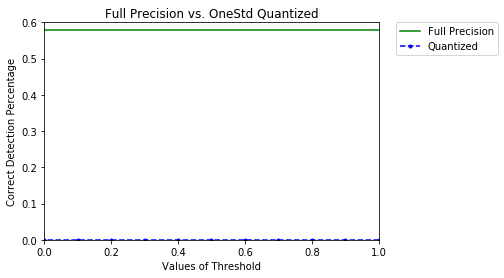

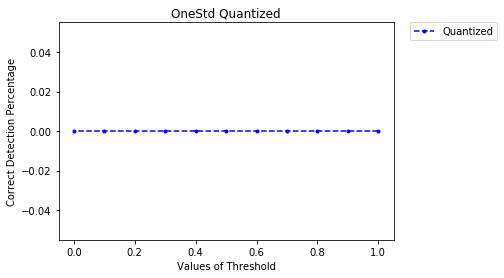

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
plot_percents("Full Precision vs. OneStd Quantized", std1_thresholds, std1_percents, True)
plot_percents("OneStd Quantized", std1_thresholds, std1_percents, False)
print(std1_percents)

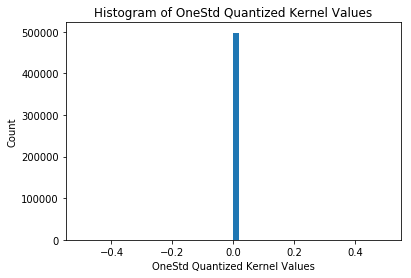

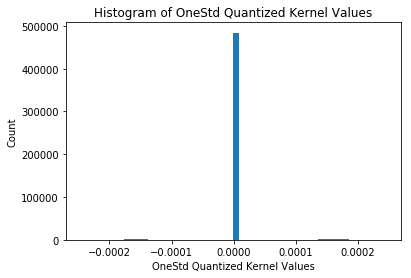

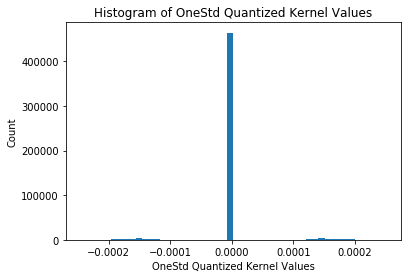

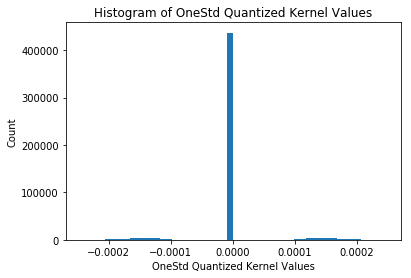

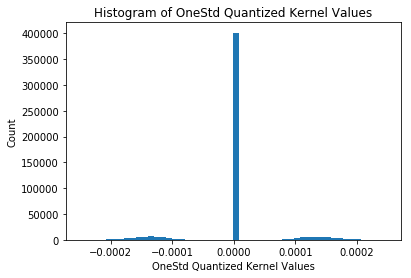

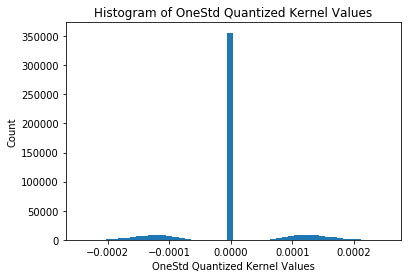

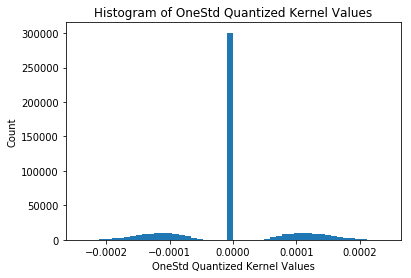

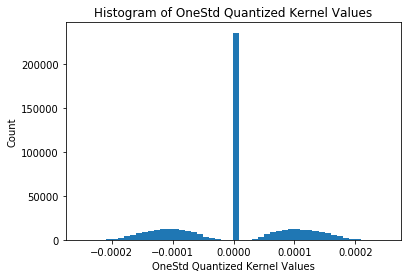

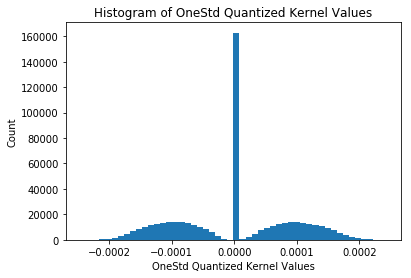

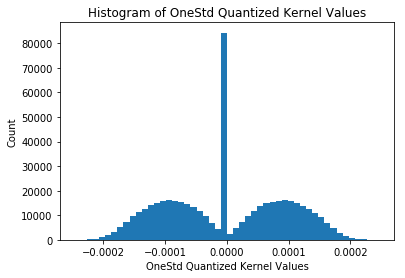

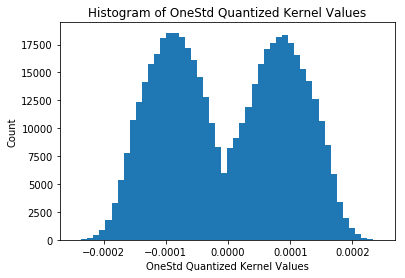

In [15]:
for i in range(num_points):
  plot_histogram(std1_tensors[i][2], "Histogram of OneStd Quantized Kernel Values", "OneStd Quantized Kernel Values", 50)

In [16]:
std2_thresholds = [1-(0.1)*i for i in range(num_points)]
std2_percents, std2_tensors = hypertune(std2_thresholds, std2)

INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  2.78537645e-05  -4.49289219e-05  -5.92922152e-05 ...,  -2.33359933e-05
    -3.62280989e-05   9.05856650e-05]
  [ -9.15185519e-05   1.23111706e-04   1.14025504e-04 ...,   8.98613362e-05
     2.46848849e-05   3.59987680e-05]
  [  5.96488571e-05   1.12693859e-04   2.69358352e-05 ...,  -1.13284332e-04
    -4.41947959e-05  -5.16896471e-05]
  ..., 
  [  1.46012637e-04  -7.02682737e-05  -1.96186331e-04 ...,   1.77121274e-05
    -1.01287005e-04  -1.84765391e-04]
  [ -8.09748017e-05  -9.27407309e-05  -8.26530086e-05 ...,  -2.54574807e-05
    -2.82802630e-05   1.03111721e-04]
  [ -4.36230366e-05   1.80428742e-05  -4.30345935e-05 ...,  -4.35086113e-05
    -3.95068637e-05   5.55263432e-05]]

 [[ -2.54883707e-05   5.94720723e-06   5.59334148e-05 ...,   4.40813928e-05
    -1.55109927e-04  -8.01125061e-05]
  [ -1.52251378e-04   1.79634644e-05   1.11363959e-04 ...,   7.73657375e-05
    -1.43319094e-05  -7.92844512e-05]
  

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.223s misc: 0.010s
im_detect: 2/100 im_read: 0.030s detect: 0.169s misc: 0.010s
im_detect: 3/100 im_read: 0.030s detect: 0.151s misc: 0.010s
im_detect: 4/100 im_read: 0.031s detect: 0.142s misc: 0.010s
im_detect: 5/100 im_read: 0.031s detect: 0.137s misc: 0.010s
im_detect: 6/100 im_read: 0.031s detect: 0.134s misc: 0.010s
im_detect: 7/100 im_read: 0.031s detect: 0.131s misc: 0.010s
im_detect: 8/100 im_read: 0.031s detect: 0.129s misc: 0.010s
im_detect: 9/100 im_read: 0.031s detect: 0.128s misc: 0.010s
im_detect: 10/100 im_read: 0.031s detect: 0.127s misc: 0.010s
im_detect: 11/100 im_read: 0.031s detect: 0.126s misc: 0.010s
im_detect: 12/100 im_read: 0.031s detect: 0.125s misc: 0.010s
im_detect: 13/100 im_read: 0.031s detect: 0.124s misc: 0.010s
im_detect: 14/100 im_read: 0.031s detect: 0.123s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  9.36127162e-06   2.10644121e-05  -1.56369890e-04 ...,   1.16646203e-04
    -1.26186860e-04  -7.44906793e-05]
  [  3.75196796e-05   1.41166413e-04   1.11065849e-04 ...,  -6.60305086e-05
     4.33575115e-05  -9.70811525e-05]
  [  8.57185387e-06   1.73008637e-04  -1.58991854e-04 ...,   1.29018896e-04
     1.19491369e-05  -1.63352859e-04]
  ..., 
  [ -3.45931330e-05   2.18296573e-05  -1.73536569e-06 ...,  -1.26678191e-04
     7.77245295e-05  -7.43408091e-05]
  [ -1.14941824e-04   4.31214030e-05   9.20115872e-06 ...,   4.92931576e-05
     2.00653812e-05  -2.09021273e-05]
  [  3.14728859e-05   9.42098413e-05  -5.34987776e-05 ...,  -4.70557425e-05
    -7.85677912e-05   1.08571097e-04]]

 [[ -1.11760804e-04   1.28150728e-04   4.13433690e-06 ...,  -8.54780956e-05
     1.37933262e-06   1.86

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.031s detect: 0.219s misc: 0.010s
im_detect: 2/100 im_read: 0.035s detect: 0.170s misc: 0.010s
im_detect: 3/100 im_read: 0.034s detect: 0.151s misc: 0.010s
im_detect: 4/100 im_read: 0.034s detect: 0.141s misc: 0.010s
im_detect: 5/100 im_read: 0.033s detect: 0.136s misc: 0.010s
im_detect: 6/100 im_read: 0.033s detect: 0.133s misc: 0.010s
im_detect: 7/100 im_read: 0.033s detect: 0.130s misc: 0.010s
im_detect: 8/100 im_read: 0.033s detect: 0.128s misc: 0.010s
im_detect: 9/100 im_read: 0.033s detect: 0.127s misc: 0.010s
im_detect: 10/100 im_read: 0.033s detect: 0.126s misc: 0.010s
im_detect: 11/100 im_read: 0.033s detect: 0.125s misc: 0.010s
im_detect: 12/100 im_read: 0.033s detect: 0.124s misc: 0.010s
im_detect: 13/100 im_read: 0.032s detect: 0.123s misc: 0.010s
im_detect: 14/100 im_read: 0.032s detect: 0.123s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.26532133e-04   9.05413399e-05   1.11450609e-04 ...,   1.30363682e-04
    -6.95212802e-05  -1.15994320e-04]
  [  1.70044859e-05   5.31044643e-05   4.99741363e-05 ...,  -1.90078834e-04
     5.90971576e-05   1.72695989e-04]
  [ -1.52951834e-05  -4.10311186e-05  -9.95339269e-06 ...,   7.80925839e-05
     1.21337674e-04   8.27319582e-06]
  ..., 
  [ -1.35939845e-05  -1.94508211e-05  -5.64039219e-05 ...,  -1.52286826e-04
    -4.77118811e-05   4.17281044e-05]
  [ -7.40425894e-05   1.08792819e-05   5.24224852e-05 ...,  -2.40484806e-05
    -1.47621968e-05  -3.03804572e-05]
  [ -1.79679831e-04  -4.93089192e-06  -1.32383924e-04 ...,   6.48025671e-05
    -7.74320724e-05   2.24069245e-05]]

 [[  1.11338647e-06   7.86189630e-05  -1.15472329e-04 ...,   5.12931692e-05
     1.70819567e-05  -1.37

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.032s detect: 0.222s misc: 0.010s
im_detect: 2/100 im_read: 0.033s detect: 0.169s misc: 0.010s
im_detect: 3/100 im_read: 0.033s detect: 0.151s misc: 0.010s
im_detect: 4/100 im_read: 0.033s detect: 0.141s misc: 0.010s
im_detect: 5/100 im_read: 0.033s detect: 0.137s misc: 0.010s
im_detect: 6/100 im_read: 0.033s detect: 0.133s misc: 0.010s
im_detect: 7/100 im_read: 0.033s detect: 0.130s misc: 0.010s
im_detect: 8/100 im_read: 0.033s detect: 0.128s misc: 0.010s
im_detect: 9/100 im_read: 0.033s detect: 0.127s misc: 0.010s
im_detect: 10/100 im_read: 0.033s detect: 0.126s misc: 0.010s
im_detect: 11/100 im_read: 0.033s detect: 0.125s misc: 0.010s
im_detect: 12/100 im_read: 0.033s detect: 0.124s misc: 0.010s
im_detect: 13/100 im_read: 0.033s detect: 0.124s misc: 0.010s
im_detect: 14/100 im_read: 0.033s detect: 0.124s misc: 0.010s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -8.03104922e-05   1.11472393e-04  -8.70286167e-05 ...,  -1.36986258e-04
    -5.50624782e-06   1.39621825e-05]
  [  7.15137674e-07   8.37131884e-05   1.19745921e-04 ...,   1.76361471e-04
    -1.66194277e-05   3.06259717e-05]
  [  6.04228189e-05   1.89855036e-05   4.04037710e-05 ...,  -1.52128807e-04
     6.41602601e-05  -1.40222415e-04]
  ..., 
  [  3.30934236e-05   7.10914028e-05  -4.34162102e-05 ...,   1.85852070e-04
     1.70167477e-04  -8.68545758e-05]
  [  2.96041871e-05   1.43294645e-04  -1.32186542e-04 ...,  -3.26922491e-05
    -7.46486185e-05   1.11063193e-04]
  [ -1.23035832e-04   4.90502271e-06  -9.13161348e-05 ...,   5.59354121e-05
    -1.46848455e-04  -9.91543784e-05]]

 [[  3.20418949e-05  -1.65616402e-05   1.14292678e-04 ...,   4.35598740e-05
     1.05237981e-04   1.27

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.034s detect: 0.228s misc: 0.011s
im_detect: 2/100 im_read: 0.034s detect: 0.172s misc: 0.011s
im_detect: 3/100 im_read: 0.033s detect: 0.153s misc: 0.011s
im_detect: 4/100 im_read: 0.033s detect: 0.142s misc: 0.011s
im_detect: 5/100 im_read: 0.033s detect: 0.138s misc: 0.011s
im_detect: 6/100 im_read: 0.033s detect: 0.133s misc: 0.011s
im_detect: 7/100 im_read: 0.033s detect: 0.130s misc: 0.011s
im_detect: 8/100 im_read: 0.033s detect: 0.128s misc: 0.011s
im_detect: 9/100 im_read: 0.033s detect: 0.127s misc: 0.011s
im_detect: 10/100 im_read: 0.033s detect: 0.126s misc: 0.011s
im_detect: 11/100 im_read: 0.033s detect: 0.125s misc: 0.011s
im_detect: 12/100 im_read: 0.033s detect: 0.124s misc: 0.011s
im_detect: 13/100 im_read: 0.033s detect: 0.124s misc: 0.011s
im_detect: 14/100 im_read: 0.033s detect: 0.123s misc: 0.011s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -3.01820382e-05   8.02669601e-05  -6.52919116e-05 ...,  -1.50431617e-04
     4.72303873e-05   1.88769511e-04]
  [ -8.99051520e-05   1.23032514e-04   2.59667122e-05 ...,  -3.09850147e-05
     1.22824946e-04  -9.11864699e-05]
  [  1.34385875e-04  -1.95511442e-04   3.17214362e-05 ...,   7.48993771e-05
     8.34356342e-06   2.68457534e-05]
  ..., 
  [ -6.22217995e-05  -9.56656149e-05  -1.27861000e-04 ...,  -2.87908333e-05
     9.56248477e-05  -7.85142256e-05]
  [  5.53119899e-05  -8.97866121e-05  -1.35471100e-05 ...,   4.36719602e-05
    -2.82674432e-06  -7.16684008e-06]
  [  1.28296830e-04  -2.25411623e-05  -5.39259963e-05 ...,   6.76105410e-05
    -5.84257286e-05   1.03599581e-04]]

 [[  1.40171294e-04   4.87634497e-05   1.67345279e-04 ...,   3.94057897e-05
     1.26236744e-04   8.75

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.033s detect: 0.224s misc: 0.016s
im_detect: 2/100 im_read: 0.033s detect: 0.173s misc: 0.016s
im_detect: 3/100 im_read: 0.036s detect: 0.155s misc: 0.016s
im_detect: 4/100 im_read: 0.035s detect: 0.146s misc: 0.016s
im_detect: 5/100 im_read: 0.035s detect: 0.140s misc: 0.016s
im_detect: 6/100 im_read: 0.034s detect: 0.136s misc: 0.016s
im_detect: 7/100 im_read: 0.034s detect: 0.133s misc: 0.016s
im_detect: 8/100 im_read: 0.033s detect: 0.131s misc: 0.016s
im_detect: 9/100 im_read: 0.033s detect: 0.129s misc: 0.016s
im_detect: 10/100 im_read: 0.033s detect: 0.127s misc: 0.016s
im_detect: 11/100 im_read: 0.033s detect: 0.127s misc: 0.016s
im_detect: 12/100 im_read: 0.032s detect: 0.126s misc: 0.016s
im_detect: 13/100 im_read: 0.032s detect: 0.125s misc: 0.016s
im_detect: 14/100 im_read: 0.032s detect: 0.125s misc: 0.016s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  4.75625238e-05  -5.52629208e-05   7.29280328e-06 ...,   1.98253856e-05
     1.22004363e-04   1.10646397e-04]
  [  1.70644980e-05  -1.29329288e-04   1.45936981e-04 ...,   8.48919171e-06
     1.29501219e-04   6.19656275e-05]
  [  2.00921822e-05   1.11731142e-05  -1.52554145e-04 ...,  -5.00719943e-05
    -7.57688467e-05  -6.03564913e-05]
  ..., 
  [  8.39477434e-05   1.83803713e-04   1.32441619e-05 ...,  -2.30367950e-05
     9.28396039e-05   1.27107225e-04]
  [ -1.80550251e-05  -6.99464144e-05  -9.57837401e-05 ...,  -8.63973764e-05
    -1.23674137e-04   1.16973621e-04]
  [ -3.88764347e-05   2.55316154e-05   1.67515958e-04 ...,  -1.67056987e-05
    -7.73472584e-06  -1.03331360e-04]]

 [[  8.94728364e-05   7.54652137e-05  -1.12952912e-04 ...,   3.76213648e-05
     7.28617233e-05  -1.48

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.217s misc: 0.016s
im_detect: 2/100 im_read: 0.031s detect: 0.167s misc: 0.016s
im_detect: 3/100 im_read: 0.031s detect: 0.150s misc: 0.016s
im_detect: 4/100 im_read: 0.031s detect: 0.141s misc: 0.016s
im_detect: 5/100 im_read: 0.031s detect: 0.136s misc: 0.016s
im_detect: 6/100 im_read: 0.031s detect: 0.134s misc: 0.016s
im_detect: 7/100 im_read: 0.031s detect: 0.132s misc: 0.016s
im_detect: 8/100 im_read: 0.031s detect: 0.131s misc: 0.016s
im_detect: 9/100 im_read: 0.031s detect: 0.129s misc: 0.016s
im_detect: 10/100 im_read: 0.032s detect: 0.127s misc: 0.016s
im_detect: 11/100 im_read: 0.032s detect: 0.126s misc: 0.016s
im_detect: 12/100 im_read: 0.032s detect: 0.126s misc: 0.016s
im_detect: 13/100 im_read: 0.032s detect: 0.125s misc: 0.016s
im_detect: 14/100 im_read: 0.032s detect: 0.124s misc: 0.016s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  1.50598344e-05   5.52870988e-05   7.66411176e-05 ...,  -1.71305132e-04
    -1.05427935e-05   6.17345650e-05]
  [  7.69488906e-05   1.26412953e-04   1.73303997e-04 ...,  -6.71920452e-06
    -1.23615348e-04   8.95103494e-06]
  [  5.16825958e-06  -1.43134806e-04   3.10052928e-05 ...,   1.02655875e-04
     5.37939413e-05   6.98839540e-06]
  ..., 
  [  1.80635368e-04  -8.67384879e-05   7.37996234e-05 ...,  -1.33431939e-04
     1.77785361e-04  -7.92064384e-05]
  [ -4.86506469e-05  -4.84682168e-05  -3.63677027e-05 ...,  -3.09868192e-05
     5.71485202e-07   4.37239905e-05]
  [ -2.86717259e-05   1.07918044e-04  -7.35743160e-05 ...,   5.04685049e-05
     2.48195975e-05   9.95944720e-05]]

 [[ -1.01068079e-04  -4.59451112e-05   1.17799646e-04 ...,  -3.89985908e-05
     4.43602694e-05  -5.69

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.030s detect: 0.223s misc: 0.016s
im_detect: 2/100 im_read: 0.030s detect: 0.171s misc: 0.016s
im_detect: 3/100 im_read: 0.030s detect: 0.152s misc: 0.016s
im_detect: 4/100 im_read: 0.031s detect: 0.143s misc: 0.016s
im_detect: 5/100 im_read: 0.031s detect: 0.139s misc: 0.051s
im_detect: 6/100 im_read: 0.031s detect: 0.136s misc: 0.045s
im_detect: 7/100 im_read: 0.031s detect: 0.133s misc: 0.041s
im_detect: 8/100 im_read: 0.031s detect: 0.130s misc: 0.038s
im_detect: 9/100 im_read: 0.031s detect: 0.129s misc: 0.035s
im_detect: 10/100 im_read: 0.031s detect: 0.128s misc: 0.033s
im_detect: 11/100 im_read: 0.031s detect: 0.128s misc: 0.032s
im_detect: 12/100 im_read: 0.031s detect: 0.127s misc: 0.031s
im_detect: 13/100 im_read: 0.031s detect: 0.126s misc: 0.029s
im_detect: 14/100 im_read: 0.031s detect: 0.126s misc: 0.028s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.56394803e-04  -2.49426212e-05   4.58210452e-05 ...,   1.78470800e-05
    -3.66474342e-05  -1.57898743e-04]
  [ -2.13789408e-05   6.34072421e-05  -5.26750118e-05 ...,   1.37246796e-04
    -3.93307664e-06   1.32897665e-04]
  [  7.29136227e-05  -1.12870068e-04  -1.18973541e-04 ...,   2.92078312e-05
    -9.33520278e-05  -2.89786749e-05]
  ..., 
  [ -1.93313936e-05  -3.22026317e-05  -8.40367793e-05 ...,  -2.57092943e-05
     7.04744816e-05  -1.01126883e-04]
  [ -1.79703391e-04  -1.54885529e-05  -8.38935230e-05 ...,   3.81522659e-05
     1.18082426e-04   4.90646744e-05]
  [  1.09088251e-04  -4.21535951e-05  -7.25394129e-05 ...,   1.02820646e-04
     3.80999109e-06   3.62165374e-05]]

 [[ -1.81851981e-04   2.41816506e-05   7.64980068e-05 ...,  -1.63315035e-05
    -7.50964828e-05  -1.45

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.032s detect: 0.227s misc: 0.013s
im_detect: 2/100 im_read: 0.032s detect: 0.174s misc: 0.014s
im_detect: 3/100 im_read: 0.033s detect: 0.155s misc: 0.014s
im_detect: 4/100 im_read: 0.033s detect: 0.146s misc: 0.014s
im_detect: 5/100 im_read: 0.033s detect: 0.140s misc: 0.014s
im_detect: 6/100 im_read: 0.033s detect: 0.136s misc: 0.014s
im_detect: 7/100 im_read: 0.033s detect: 0.133s misc: 0.014s
im_detect: 8/100 im_read: 0.033s detect: 0.131s misc: 0.014s
im_detect: 9/100 im_read: 0.033s detect: 0.129s misc: 0.014s
im_detect: 10/100 im_read: 0.033s detect: 0.127s misc: 0.014s
im_detect: 11/100 im_read: 0.033s detect: 0.126s misc: 0.014s
im_detect: 12/100 im_read: 0.033s detect: 0.126s misc: 0.014s
im_detect: 13/100 im_read: 0.033s detect: 0.125s misc: 0.014s
im_detect: 14/100 im_read: 0.033s detect: 0.124s misc: 0.014s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -1.02446473e-04  -2.10300732e-05  -5.57670173e-05 ...,  -4.16533803e-05
    -1.79533876e-04   9.11462339e-05]
  [ -5.81282075e-05   9.86651116e-07   8.32183723e-05 ...,   1.96656430e-04
     3.40471634e-05  -2.75821731e-05]
  [ -1.41297332e-05   4.47082894e-05   1.67917533e-05 ...,   5.49977340e-05
    -8.81650485e-05   8.77308121e-05]
  ..., 
  [ -9.49240275e-05   5.57690146e-05   9.89150285e-05 ...,   1.12940521e-04
    -4.69422557e-05  -6.12174554e-05]
  [ -7.62722339e-05  -1.27983440e-04  -8.93933466e-05 ...,   1.07153377e-04
     5.92833640e-05   8.26418982e-05]
  [ -1.88797392e-04  -6.32469309e-05  -1.62851036e-04 ...,   4.40849726e-05
     9.96266863e-06   5.92482866e-05]]

 [[  1.41989731e-05  -3.61816528e-05   9.08678485e-05 ...,  -5.79854604e-05
     7.86753153e-05  -3.66

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.033s detect: 0.222s misc: 0.014s
im_detect: 2/100 im_read: 0.034s detect: 0.169s misc: 0.014s
im_detect: 3/100 im_read: 0.033s detect: 0.152s misc: 0.014s
im_detect: 4/100 im_read: 0.033s detect: 0.143s misc: 0.014s
im_detect: 5/100 im_read: 0.033s detect: 0.137s misc: 0.014s
im_detect: 6/100 im_read: 0.033s detect: 0.134s misc: 0.014s
im_detect: 7/100 im_read: 0.032s detect: 0.132s misc: 0.014s
im_detect: 8/100 im_read: 0.032s detect: 0.130s misc: 0.014s
im_detect: 9/100 im_read: 0.032s detect: 0.129s misc: 0.014s
im_detect: 10/100 im_read: 0.032s detect: 0.128s misc: 0.014s
im_detect: 11/100 im_read: 0.032s detect: 0.126s misc: 0.014s
im_detect: 12/100 im_read: 0.032s detect: 0.126s misc: 0.014s
im_detect: 13/100 im_read: 0.032s detect: 0.125s misc: 0.014s
im_detect: 14/100 im_read: 0.032s detect: 0.125s misc: 0.014s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[  8.64051253e-06  -1.42732570e-05   4.97780529e-05 ...,  -3.06153306e-05
    -1.22120633e-04  -9.28727750e-05]
  [ -7.08719526e-05  -7.52497508e-05   5.52546844e-05 ...,  -8.69647047e-05
     6.67149579e-05  -6.75168776e-05]
  [ -2.80583135e-05  -8.38761844e-06  -2.50881003e-05 ...,  -1.57848757e-04
     1.41402546e-04  -6.70477748e-05]
  ..., 
  [  2.30682490e-05   7.44593126e-05  -6.74416224e-05 ...,   1.47770479e-04
     1.75986323e-04   1.84304430e-04]
  [  1.22163226e-04  -1.81670868e-04  -1.77211914e-04 ...,  -1.28237916e-05
     1.89630157e-06   1.14984578e-04]
  [ -1.25942470e-05   2.90617936e-05  -7.05730099e-06 ...,   1.37500814e-04
     1.67570557e-04   8.66635673e-05]]

 [[ -1.08752953e-04   7.95487649e-05  -2.43944214e-05 ...,  -1.29746521e-04
    -3.37289225e-06   6.25

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.032s detect: 0.226s misc: 0.009s
im_detect: 2/100 im_read: 0.033s detect: 0.168s misc: 0.009s
im_detect: 3/100 im_read: 0.033s detect: 0.150s misc: 0.009s
im_detect: 4/100 im_read: 0.033s detect: 0.142s misc: 0.009s
im_detect: 5/100 im_read: 0.033s detect: 0.136s misc: 0.009s
im_detect: 6/100 im_read: 0.033s detect: 0.133s misc: 0.009s
im_detect: 7/100 im_read: 0.033s detect: 0.130s misc: 0.009s
im_detect: 8/100 im_read: 0.033s detect: 0.128s misc: 0.009s
im_detect: 9/100 im_read: 0.033s detect: 0.127s misc: 0.009s
im_detect: 10/100 im_read: 0.033s detect: 0.126s misc: 0.009s
im_detect: 11/100 im_read: 0.033s detect: 0.125s misc: 0.009s
im_detect: 12/100 im_read: 0.033s detect: 0.125s misc: 0.009s
im_detect: 13/100 im_read: 0.032s detect: 0.124s misc: 0.009s
im_detect: 14/100 im_read: 0.032s detect: 0.124s misc: 0.009s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.
INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.
0 [[[ -2.76264782e-05   4.50764237e-05  -1.64662575e-04 ...,  -8.43379239e-05
     3.49398142e-05  -4.59236144e-05]
  [  9.24203996e-05  -1.38395362e-05   3.31520982e-06 ...,  -9.07256835e-05
     8.07205797e-05  -7.56769305e-06]
  [ -6.78403667e-05  -1.56992683e-05  -2.05707584e-05 ...,  -1.57197326e-04
     7.19180534e-05   1.17150539e-05]
  ..., 
  [  1.38772026e-04  -7.08688094e-05   3.29541363e-05 ...,   8.99021597e-06
    -4.63456345e-05   8.30310310e-05]
  [ -5.94469057e-05  -6.47794377e-06   1.40074946e-04 ...,  -1.23439851e-04
    -1.35577822e-04  -5.16995424e-05]
  [ -5.68497717e-06  -1.79911265e-04   4.09638669e-05 ...,   3.20839126e-06
    -4.64304103e-05  -1.23553377e-06]]

 [[  7.34705536e-05  -1.66635346e-05   1.74772707e-04 ...,   1.90923573e-04
     3.23146160e-05  -1.24

INFO:tensorflow:Restoring parameters from /rscratch/ruta/squeezeDet/data/model_checkpoints/squeezeDet/model.ckpt-87000
im_detect: 1/100 im_read: 0.032s detect: 0.219s misc: 0.013s
im_detect: 2/100 im_read: 0.033s detect: 0.167s misc: 0.013s
im_detect: 3/100 im_read: 0.032s detect: 0.153s misc: 0.013s
im_detect: 4/100 im_read: 0.032s detect: 0.144s misc: 0.012s
im_detect: 5/100 im_read: 0.032s detect: 0.138s misc: 0.012s
im_detect: 6/100 im_read: 0.032s detect: 0.135s misc: 0.012s
im_detect: 7/100 im_read: 0.032s detect: 0.134s misc: 0.012s
im_detect: 8/100 im_read: 0.032s detect: 0.131s misc: 0.012s
im_detect: 9/100 im_read: 0.032s detect: 0.129s misc: 0.012s
im_detect: 10/100 im_read: 0.032s detect: 0.128s misc: 0.012s
im_detect: 11/100 im_read: 0.032s detect: 0.127s misc: 0.012s
im_detect: 12/100 im_read: 0.031s detect: 0.126s misc: 0.012s
im_detect: 13/100 im_read: 0.031s detect: 0.125s misc: 0.012s
im_detect: 14/100 im_read: 0.031s detect: 0.125s misc: 0.012s
im_detect: 15/100 im_r

INFO:tensorflow:Summary name Detection Analysis/% repeated error is illegal; using Detection_Analysis/__repeated_error instead.


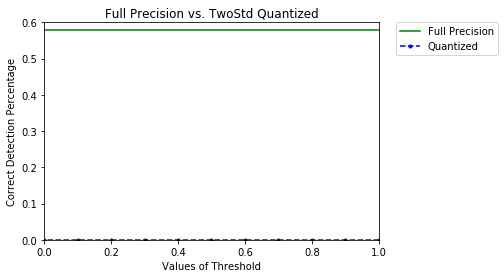

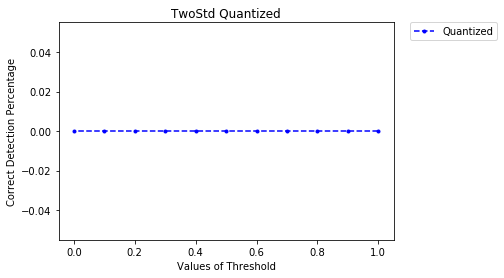

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
plot_percents("Full Precision vs. TwoStd Quantized", std2_thresholds, std2_percents, True)
plot_percents("TwoStd Quantized", std2_thresholds, std2_percents, False)
print(std2_percents)

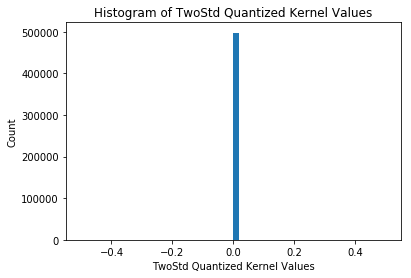

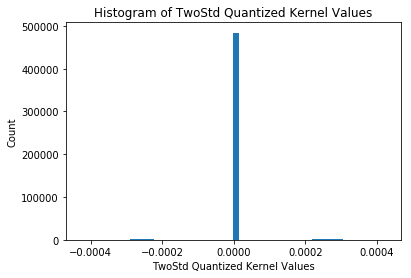

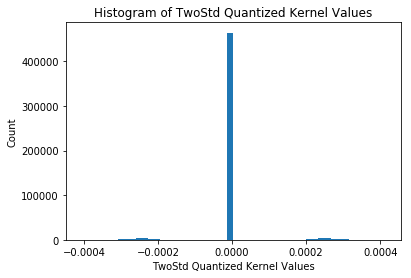

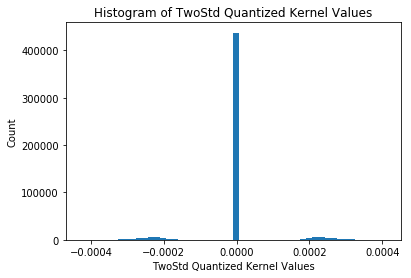

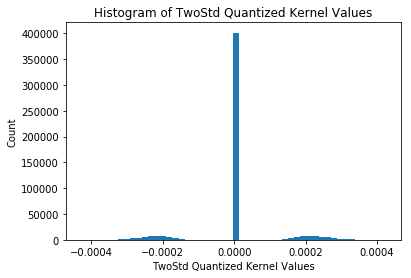

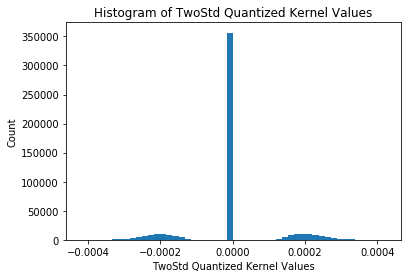

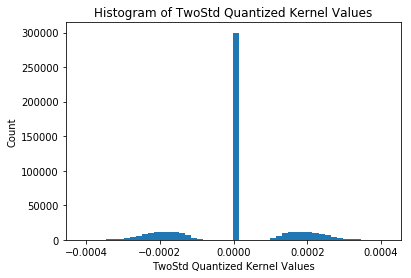

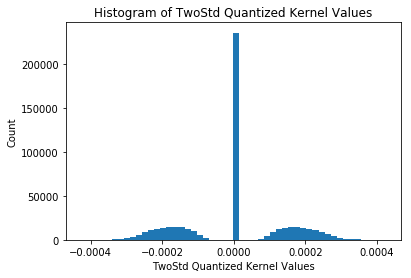

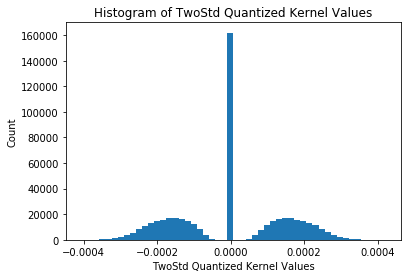

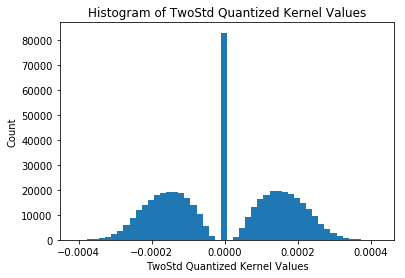

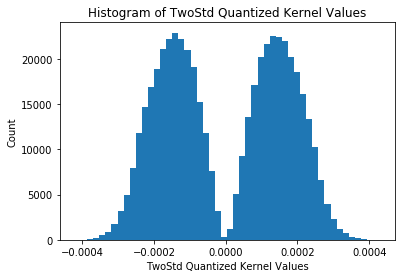

In [18]:
for i in range(num_points):
  plot_histogram(std2_tensors[i][2], "Histogram of TwoStd Quantized Kernel Values", "TwoStd Quantized Kernel Values", 50)